<a href="https://colab.research.google.com/github/inna-vogel/Write-like-Goethe-with-GPT-2_Textgenerierung-mit-GPT-2/blob/main/Goethe_GPT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Write like Goethe with GPT-2 (German)**
# **Schreibe wie Goethe mit GPT-2 (Deutsch)** 
---
---

This Notebook is inspired by: https://www.philschmid.de/fine-tune-a-non-english-gpt-2-model-with-huggingface


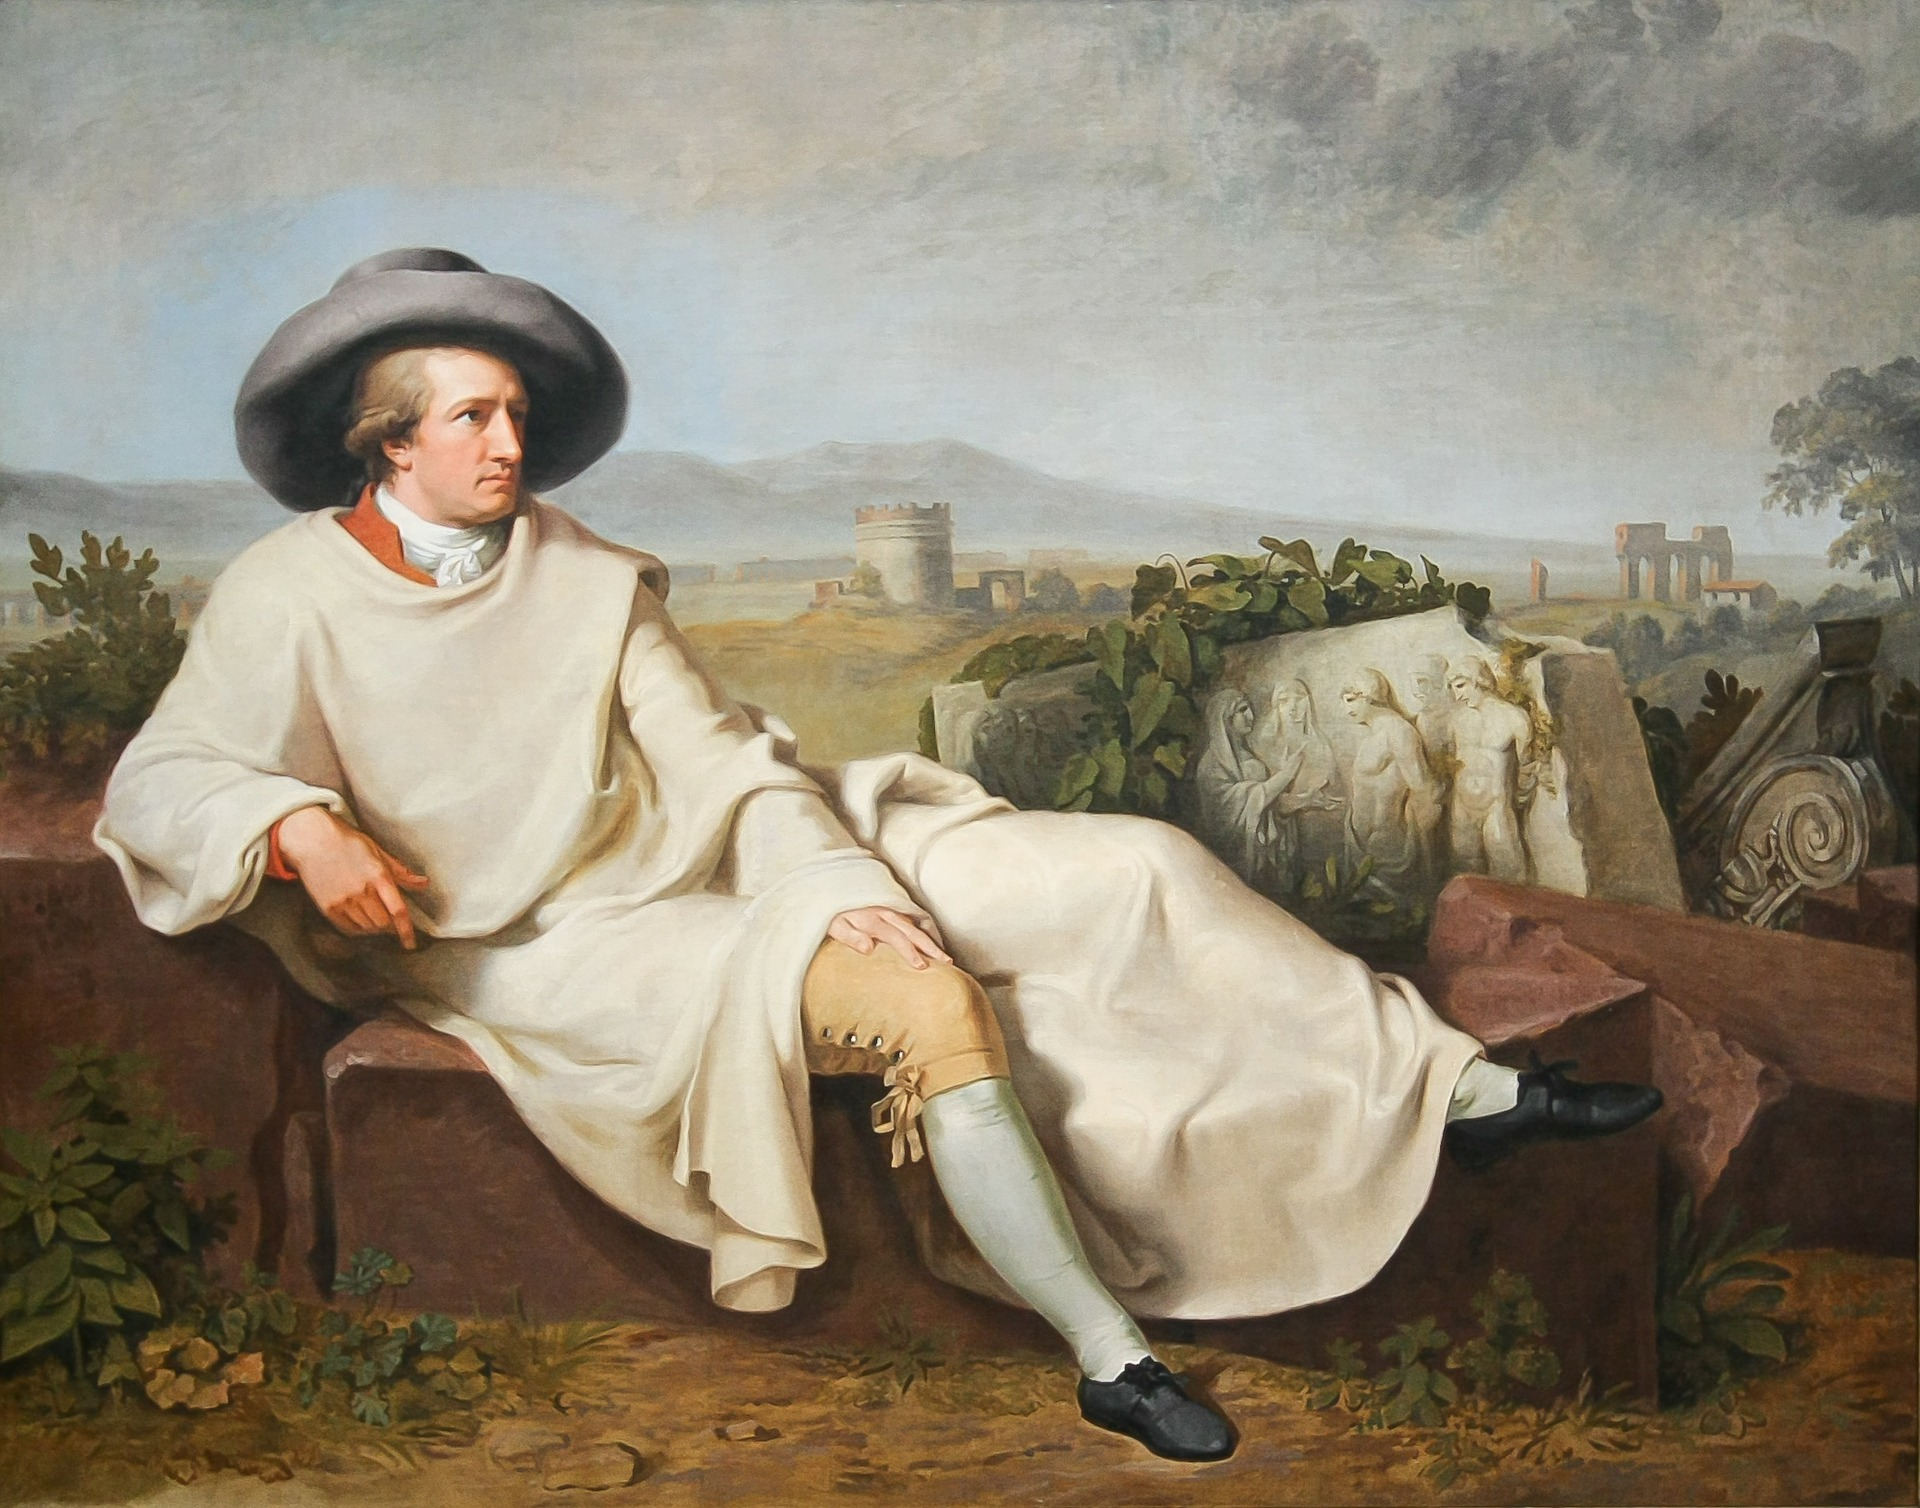

In [22]:
# install transformers

pip install transformers #==3.1.0

In [23]:
#Connect to your drive folder

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [14]:
import re
import json
from sklearn.model_selection import train_test_split


with open('/content/drive/My Drive/Colab Notebooks/Goethe Johann Wolfgang.json') as f: #path to the Goethe texts in your Drive folder
    data = json.load(f) #load file

def build_text_files(data_json, dest_path):
    f = open(dest_path, 'w')
    data = ''
    for texts in data_json:
        summary = str(texts['text']).strip() #extract just the text from the .json file
        summary = re.sub(r"\s", " ", summary)
        data += summary + "  "
    f.write(data)


In [15]:
#divide data in training and test set

train, test = train_test_split(data,test_size=0.15) 

#extract the text from .json file for train and test set
build_text_files(train,'train_dataset.txt')
build_text_files(test,'test_dataset.txt')

#let's check how long the train and test data set is
print("Train dataset length: "+str(len(train)))
print("Test dataset length: "+ str(len(test)))

Train dataset length: 504
Test dataset length: 89


In [16]:
from transformers import AutoTokenizer

# download the tokenizer: we use the tokenizer from the german-gpt2 model on huggingface.get the GPT-2 model
tokenizer = AutoTokenizer.from_pretrained("anonymous-german-nlp/german-gpt2")

train_path = 'train_dataset.txt'
test_path = 'test_dataset.txt'

In [17]:
from transformers import TextDataset,DataCollatorForLanguageModeling

#load and tokenize the texts in train and test set
def load_dataset(train_path,test_path,tokenizer):
    train_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=train_path,
          block_size=128)
     
    test_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=test_path,
          block_size=128)   
    
    """Data collator is used for language modeling. Inputs are dynamically padded to the maximum length of a batch if they
    are not all of the same length."""
    
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=False,
    )
    return train_dataset,test_dataset,data_collator


train_dataset,test_dataset,data_collator = load_dataset(train_path,test_path,tokenizer)

/usr/local/lib/python3.6/dist-packages/transformers/data/datasets/language_modeling.py:44: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/language-modeling/run_mlm.py
  FutureWarning,


The Trainer class provides an API for training. 

First we need to download the GPT-2 model and create a TrainingArguments to access all the points of customization during training. In the TrainingArguments, we can define the Hyperparameters we are going to use in the training process like learning_rate, num_train_epochs, per_device_train_batch_size. 

More information: https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments

In [20]:
from transformers import Trainer, TrainingArguments,AutoModelWithLMHead

model = AutoModelWithLMHead.from_pretrained("anonymous-german-nlp/german-gpt2")


training_args = TrainingArguments(
    output_dir="./gpt2-Goethe", #output directory
    overwrite_output_dir=True, #if file exists, override
    num_train_epochs=10, # number of training epochs
    per_device_train_batch_size=32, # batch size for training
    per_device_eval_batch_size=64,  # batch size for evaluation
    eval_steps = 400, # Number of update steps between two evaluations.
    save_steps=800, # after # steps model is saved 
    warmup_steps=500,# number of warmup steps for learning rate scheduler
    )


trainer = Trainer(
    model=model, #use the German GPT-2 model
    args=training_args, #training arguments and hyperparameters
    data_collator=data_collator, #data collator
    train_dataset=train_dataset, #train set
    eval_dataset=test_dataset, #evaluation data
    prediction_loss_only=True,
)

/usr/local/lib/python3.6/dist-packages/transformers/modeling_auto.py:837: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/trainer.py:281: FutureWarning: Passing `prediction_loss_only` as a keyword argument is deprecated and won't be possible in a future version. Use `args.prediction_loss_only` instead. Setting `args.prediction_loss_only=True
  FutureWarning,


Train model and save 

In [21]:
trainer.train()
trainer.save_model("/content/drive/My Drive/Colab Notebooks/trained-goethe-model")

Step,Training Loss
500,4.766356
1000,3.949201


### Now you just have put everything together and start writing like Goethe :-)

In [24]:
from transformers import AutoModelWithLMHead, AutoTokenizer
from transformers import AutoTokenizer

# use GPT-2 for tokenizing to encode and decode the input and output text
tokenizer = AutoTokenizer.from_pretrained("anonymous-german-nlp/german-gpt2") 

# use our fine-tunes GPT-2 model
model = AutoModelWithLMHead.from_pretrained("/content/drive/My Drive/Colab Notebooks/trained-goethe-model")

# HERE you can type the text of your choice you want the be continued by GPT-2
prompt = "Der Liebende seiner Geliebten"
inputs = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt")
prompt_length = len(tokenizer.decode(inputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True))

""" max_length = max length of text you want to generate

top_k=0 - In Top-K sampling, the K most likely next words are filtered and the probability mass is redistributed among only those K next words. 
1 means top 1 word is considered for each step (token), resulting in repetitive completions 40 means 40 words are considered at each step. 
0 (default) is a special setting meaning no restrictions. 40 generally is a good value.

top_p=0.0 - Instead of sampling only from the most likely K words, in Top-p sampling chooses from the smallest possible set of words whose cumulative 
probability exceeds the probability p. Having set p=0.92, the model will select the tokens exceeding 92% probability of next tokens 
= sample only from 92% most likely words. 
"""


outputs = model.generate(inputs, max_length=250, do_sample=True, top_p=0.95, top_k=60) 
generated = prompt + tokenizer.decode(outputs[0])[prompt_length:]

print(generated)

/usr/local/lib/python3.6/dist-packages/transformers/modeling_auto.py:837: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Der Liebende seiner Geliebten, Und seine Lieben ist der Tod: Er wird die Nacht allein nicht überstehen. – Uns freut er und ist sehr froh, wenn er sie findet. Da muß ein Mann sich dem liebenden Ich übergeben Und mit dem Schönen im Paradies verbunden sein. Hier sind wir so allein und sinnend und behende, Wirst unsre Hoffnungen mit dem Schein des ewig Guten verbinden, Wirst uns zu den Guten wenden, Wirst uns dem Guten nach dem Gewinne hassen.  Wenn der Mond am Himmel steht, Die Sterne schwanken; Der Sterne Schein trügt Der Nacht, die mich hält. So viel mir das Herz im Innern schlägt, Es ist alles schön und voll.  Wer sich zum Dichter hingibt, Wird auch an ihm Gefallen finden, Er lernt bald die Kunst schätzen, Dann wird sein Wort zur Gunst der Musen, Die ein Dichter nur zu seinem Bilde baut. Wie der Dichter auf seinem Weg Und des Herzens Saat im Busen wässert, Das er auf der Erde wächst, Wie die Welt ihn ernährt, Der das Herz auf der Erde starrt, Und sein Herz im Augenblick der Not ergießt

Well Done!